In [1]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import zipfile
import requests


In [6]:
# OPTION C: Create a tiny synthetic dataset (random/noisy images with simple labeling)
import numpy as np, os
from PIL import Image, ImageDraw

OUTDIR = "synthetic_dataset"
os.makedirs(os.path.join(OUTDIR, "ulcer"), exist_ok=True)
os.makedirs(os.path.join(OUTDIR, "normal"), exist_ok=True)

def make_ulcer_image(path, size=(128,128), seed=None):
    img = Image.new("RGB", size, (230,200,200))
    draw = ImageDraw.Draw(img)
    np.random.seed(seed)
    # draw a reddish irregular blob to simulate ulcer
    for _ in range(1200):
        x = np.random.randint(10,size[0]-10)
        y = np.random.randint(10,size[1]-10)
        r = np.random.randint(1,6)
        draw.ellipse((x-r,y-r,x+r,y+r), fill=(200+np.random.randint(0,40),30+np.random.randint(0,60),30+np.random.randint(0,60)))
    img.save(path)

def make_normal_image(path, size=(128,128), seed=None):
    img = Image.new("RGB", size, (220,180,170))
    draw = ImageDraw.Draw(img)
    np.random.seed(seed)
    # add light freckles / texture
    for _ in range(200):
        x = np.random.randint(0,size[0])
        y = np.random.randint(0,size[1])
        r = np.random.randint(0,3)
        draw.ellipse((x-r,y-r,x+r,y+r), fill=(180+np.random.randint(0,30),120+np.random.randint(0,40),120+np.random.randint(0,40)))


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator for rescaling and splitting
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load dataset from the folder created earlier
train_data = datagen.flow_from_directory(
    "/content/synthetic_dataset",              # path where dataset is saved
    target_size=(128, 128), # resize images
    batch_size=4,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "/content/synthetic_dataset",
    target_size=(128, 128),
    batch_size=4,
    class_mode='binary',
    subset='validation'
)


Found 9 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [16]:
# Step 4: Build a simple CNN model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.7278 - loss: 1.7490 - val_accuracy: 0.5000 - val_loss: 0.9208
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4472 - loss: 1.0205 - val_accuracy: 0.5000 - val_loss: 0.8192
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4333 - loss: 0.7047 - val_accuracy: 0.0000e+00 - val_loss: 0.7748
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9444 - loss: 0.4562 - val_accuracy: 0.5000 - val_loss: 0.8442
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.2936 - val_accuracy: 0.5000 - val_loss: 0.9080
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.3397 - val_accuracy: 0.5000 - val_loss: 0.9674
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.2652 - val_accuracy: 0.0000e+00 - val_loss: 1.3349
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8944 - loss: 0.1506 - val_accuracy: 0.5000 - va

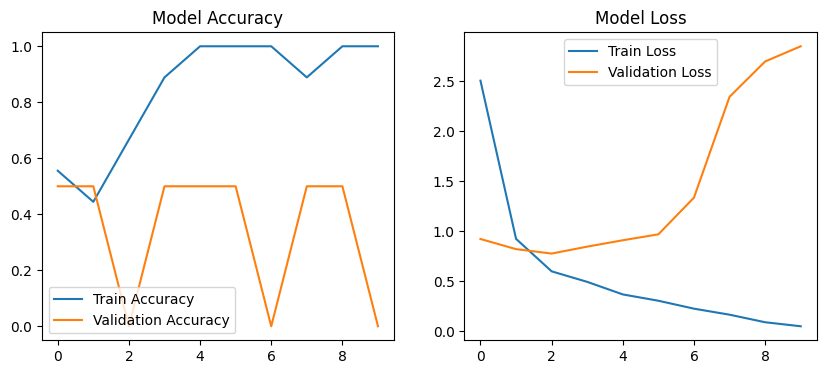

In [18]:
# Step 6: Plot Accuracy and Loss graphs
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [21]:
# Step 7: Evaluate performance
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0000e+00 - loss: 2.8501
Validation Accuracy: 0.00%
Validation Loss: 2.8501


Saving photo 2.jpg to photo 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


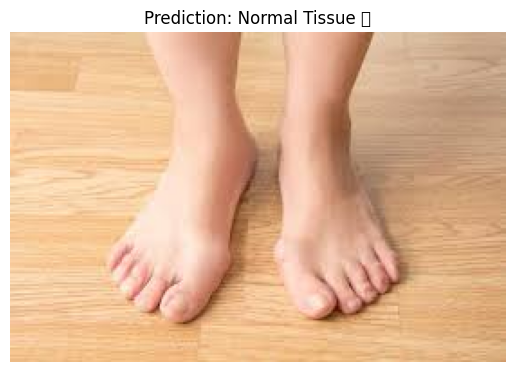

🔍 Prediction result: Normal Tissue ✅


In [24]:
# Step 8: Upload an image and get prediction result
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Upload an image file (JPG/PNG)
uploaded = files.upload()

# 2️⃣ Pick the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# 3️⃣ Preprocess the uploaded image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 4️⃣ Predict using the trained CNN model
prediction = model.predict(img_array)
label = "Ulcer Detected 🩸" if prediction[0][0] > 0.5 else "Normal Tissue ✅"

# 5️⃣ Show the uploaded image and result
plt.imshow(image.load_img(img_path))
plt.title(f"Prediction: {label}")
plt.axis("off")
plt.show()

# 6️⃣ Print conclusion
print("🔍 Prediction result:", label)
